In [1]:
from IPython.display import HTML
import io
import base64
#video = io.open('/media/Shared/Documents/CAMP-2016/tutorials/STP/NT_release.mp4', 'r+b').read()
#encoded = base64.b64encode(video)
#videoData = '''<video alt="test" controls> <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'serif', u'transition': 'zoom'}

## Overview of what all we have done until now

# Short-term synaptic plasticity

Changes in synaptic efficacy over time as a function of presynaptic activity.

## Two types of STP:

* **Short-term depression (STD)**: Caused by depletion of neurotransmitters during the process of synaptic signaling at the axon terminal of a pre-synaptic neuron.

* **Short-term facilitation (STF)  
**: Caused by influx of $Ca^{2+}$ into the axon terminal after spike generation, which increases the release probability of neurotransmitters.

## Modeling short term synaptic plasticity

 [ *Misha Tsodyks and Si Wu (2013), Scholarpedia, 8(10):3153* ]

* **STD** effect is modeled by a normalized variable $ x \in [0,1]$, fraction of resources that remain available after neurotransmitter depletion. 

* The **STF** effect is modeled by a utilization parameter $u \in [0,U]$, representing the fraction of available resources ready for use (**release probability**). 

Thus, following a spike, 
1. $u$ increases due to spike-induced calcium influx to the presynaptic terminal, after which 
2. A fraction $u$ of available resources is consumed to produce the post-synaptic current. 
3. Between spikes, $u$ decays back to zero with time constant $τ_f$ and $x$ recovers to $1$ with time constant $τ_d$.

$$
\begin{aligned}
\frac{du}{dt} = -\frac{u}{\tau_f} + U(1-u^-)\delta(t-t_{sp}) \\
\frac{dx}{dt} = \frac{1-x}{\tau_d} - u^+x^ -\delta(t-t_{sp}) \\
\frac{dI}{dt} = -\frac{I}{\tau_s} + Au^+x^ -\delta(t-t_{sp}), \\
\end{aligned}
$$

$t_{sp}$: time of spike,
$U$: increment of $u$ produced by a spike.
$u^−, x^- \& u^+ $ corresponding variables just before the arrival and the moment just after the spike respectively.

From the first equation, $u^+=u^− + U(1 − u^−)$. The synaptic current generated at the synapse by the spike arriving at $t_{sp}$ is then given by $ ΔI(t_{sp}) = A u^+ x^− $

$A$ : Absolute synaptic efficacy, or the response amplitude that would be produced by total release of all the neurotransmitter ($u=x=1$).

## Now let's model it with Brian.

In [2]:
%matplotlib inline
from brian2 import *

## Number of input and output neurons
N = 10

eqs = '''
dpreVolt/dt=r : 1
r : Hz
'''
spikingNeurons = NeuronGroup(N, model=eqs, threshold='preVolt>1.', reset='preVolt=0.')
spikingNeurons.r = linspace(5 * Hz, 30 * Hz, N)

#store()
#input_spikes = SpikeMonitor(spikingNeurons)
#run(1000 * ms)
#plot(input_spikes.t, input_spikes.i, '|k')
#xlabel('Time (ms)')
#ylabel('Neuron index')
#show()
#restore()

/usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
WARNING    /usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


In [3]:
## Let us initialize variables for the output neurons.

tau_s = 3 * ms # Decay current
tau_m = 10 * ms # Decay of membrane potential
Rm = 100 * Mohm # Membrane resistance

eqs_neuron = '''
dv/dt=(Rm*I-v)/tau_m:volt
dI/dt=-I/tau_s:amp
'''
outputNeurons = NeuronGroup(N, model=eqs_neuron)

In [8]:
## Let's put synapses between these groups of neurons.

A_SE = 250 * pA # Absolute synaptic efficacy

#taud=1*ms # Decay time synaptic depression
#tauf=100*ms # Decay time synaptic facilitation
#U=.1 # Release probability

taud=100*ms # Decay time synaptic depression
tauf=10*ms # Decay time synaptic facilitation
U=.2 # Release probability

In [9]:
S=Synapses(spikingNeurons, outputNeurons,
           model='''w : amp
                    dx/dt=(1-x)/taud : 1
                    du/dt=(-u)/tauf : 1
                 ''',
           on_pre=''' u+=U*(1-u)
                  I+=w*u*x
                  x-= x*u''')

S.connect('i==j') # one to one connection
S.w=A_SE # Initializing synaptic weights to absolute synaptic efficacy

# Initialization of STP variables

S.x = 1 # Fraction of resources that remain available after neurotransmitter depletion 
S.u = U # Fraction of available resources ready for use (release probability)

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [10]:
## Setting up monitors
recordingNeurons = [0, N/2, N - 1]
trace = StateMonitor(outputNeurons, 'v', record=recordingNeurons)
u_vals = StateMonitor(S, 'u', record=recordingNeurons)
x_vals = StateMonitor(S, 'x', record=recordingNeurons)

#monitors = [trace, u_vals, x_vals]
#net = Network(collect())  # automatically include G and S
#net.add(monitors)  # manually add the monitors

run(1000 * ms)

for i, index in enumerate(recordingNeurons):
    subplot(3,1,i+1)
    plot(trace.t/ms, trace.v[i] / mV)
    title('Vm_' + str(index))
xlabel("Time")
ylabel("$V_m$")
tight_layout()
show()

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

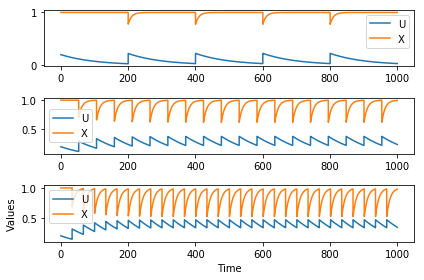

In [7]:
for i, index in enumerate(recordingNeurons):
    subplot(3,1,i+1)
    plot(u_vals.t / ms, u_vals.u[i], label = 'U')
    plot(x_vals.t / ms, x_vals.x[i], label = 'X')
    legend()
xlabel("Time")
ylabel("Values")
tight_layout()
show()

### Can you find when facilitating synapses change to depressing?

## Population signal

In [ ]:
%matplotlib inline
from brian2 import *

avgPot = []
## Number of input and output neurons
N = 10
F = 2 * Hz

eqs = '''
dpreVolt/dt=r : 1
r : Hz
'''
poissonNeurons = PoissonGroup(N, rates=F)

#store()
#input_spikes = SpikeMonitor(poissonNeurons)
#run(1000 * ms)
#plot(input_spikes.t, input_spikes.i, '.k')
#xlabel('Time (ms)')
#ylabel('Neuron index')
#show()
#restore()

In [ ]:
## Let us initialize variables for the output neurons.
numOut = 1

tau_e = 3 * ms # Decay current
tau_m = 10 * ms # Decay of membrane potential
Rm = 100 * Mohm # Membrane resistance

eqs_neuron = '''
dv/dt=(Rm*I-v)/tau_m:volt
dI/dt=-I/tau_e:amp
'''
outputNeurons = NeuronGroup(numOut, model=eqs_neuron)

In [ ]:
## Let's put synapses between these groups of neurons.

A_SE = 250 * pA # Absolute synaptic efficacy

taud=100*ms # Decay time synaptic depression
tauf=3*ms # Decay time synaptic facilitation
U=.1 # Release probability

#taud=100*ms # Decay time synaptic depression
#tauf=10*ms # Decay time synaptic facilitation
#U=.6 # Release probability

In [ ]:
S=Synapses(poissonNeurons, outputNeurons,
           model='''w : amp
                    dx/dt=(1-x)/taud : 1 (clock-driven)
                    du/dt=(-u)/tauf : 1 (clock-driven)
                 ''',
           on_pre=''' u+=U*(1-u)
                  I+=w*u*x
                  x-= x*u''')

                  
S.connect( 'j==0') # all to one connection
S.w=A_SE # Initializing synaptic weights to absolute synaptic efficacy

# Initialization of STP variables

S.x = 1 # Fraction of resources that remain available after neurotransmitter depletion 
S.u = U # Fraction of available resources ready for use (release probability)

In [ ]:
## Setting up monitors
trace = StateMonitor(outputNeurons, 'v', record=[0])
u_vals = StateMonitor(S, 'u', record=[0])
x_vals = StateMonitor(S, 'x', record=[0])

#monitors = [trace, u_vals, x_vals]
#net = Network(collect())  # automatically include G and S
#net.add(monitors)  # manually add the monitors

run(1000 * ms)

plot(trace.t/ms, trace.v[0] / mV)
avgPot.append(np.average(trace.v[0]))
title('Vm_' + str(numOut))
tight_layout()
show()

In [ ]:
plot(trace.t/ms, u_vals.u[0])
plot(trace.t/ms, x_vals.x[0])
title('Vm_' + str(numOut))
tight_layout()
show()

### Input-frequency versus Average Post-synaptic voltage

In [19]:
from brian2 import *

avgPot = []
x_arr = []
freq_array = np.arange(1,100,5)
for F in freq_array * Hz:
    ## Number of input and output neurons
    N = 500
    #F = 2 * Hz
    
    eqs = '''
    dpreVolt/dt=r : 1
    r : Hz
    '''
    poissonNeurons = PoissonGroup(N, rates=F)
    
    ## Let us initialize variables for the output neurons.
    numOut = 1
    
    tau_e = 3 * ms # Decay current
    tau_m = 25 * ms # Decay of membrane potential
    Rm = 100 * Mohm # Membrane resistance
    
    eqs_neuron = '''
    dv/dt=(Rm*I-v)/tau_m:volt
    dI/dt=-I/tau_e:amp
    '''
    outputNeurons = NeuronGroup(numOut, model=eqs_neuron)
    
    ## Let's put synapses between these groups of neurons.
    
    A_SE = 250 * pA # Absolute synaptic efficacy
    
    taud=700*ms # Decay time synaptic depression
    tauf=3*ms # Decay time synaptic facilitation
    U=.4 # Release probability
    
    #taud=100*ms # Decay time synaptic depression
    #tauf=10*ms # Decay time synaptic facilitation
    #U=.6 # Release probability
    
    S=Synapses(poissonNeurons, outputNeurons,
               model='''w : amp
                        dx/dt=(1-x)/taud : 1 (clock-driven)
                        du/dt=(-u)/tauf : 1 (clock-driven)
                     ''',
               on_pre='''u+=U*(1-u)
                  I+=w*u*x
                  x-= x*u''')
    
                      
    S.connect( 'j==0') # one to one connection
    S.w=A_SE # Initializing synaptic weights to absolute synaptic efficacy
    
    # Initialization of STP variables
    
    S.x = 1 # Fraction of resources that remain available after neurotransmitter depletion 
    S.u = U # Fraction of available resources ready for use (release probability)
    
    ## Setting up monitors
    trace = StateMonitor(outputNeurons, 'v', record=[0])
    u_vals = StateMonitor(S, 'u', record=[0])
    x_vals = StateMonitor(S, 'x', record=[0])
    
    #monitors = [trace, u_vals, x_vals]
    #net = Network(collect())  # automatically include G and S
    #net.add(monitors)  # manually add the monitors
    
    run(1000 * ms)
    
    avgPot.append(np.average(trace.v[0]))
    x_arr.append(np.average(x_vals.x[0]))
    #plot(trace.t/ms, trace.v[0] / mV)
    #title('Vm_' + str(numOut))
    
    #tight_layout()
    #show()

plt.plot(freq_array, avgPot, xlabel="Input Frequency", ylabel="Average Voltage")
plt.show()

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.